In [28]:
import numpy as np


def loss(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)


def loss_d(y_true, y_pred):
    return 2 * y_pred - 2 * y_true


def sigm_fun(x):
    return 1 / (1 + np.exp(-x))


def sigm_d(sigm_val):
    return sigm_val * (1 - sigm_val)


def relu(x):
    return 0 if x < 0 else x


def relu_d(relu_val):
    return 0 if relu_val <= 0 else 1

def tanh(x):
    return np.tanh(x)

def tanh_d(tanh_val):
    return 1 - tanh_val**2

def softmax(outputs):
    exp_outputs = [math.exp(o) for o in outputs]
    total = sum(exp_outputs)
    return [eo / total for eo in exp_outputs]


def cross_entropy_loss(y_true, y_pred):
    y_true = int(y_true - 1)
    return -(
        y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)
    )


def cross_entropy_loss_d(y_true, y_pred):
    y_true = int(y_true - 1)
    return y_pred - y_true


class Neuron:
    def __init__(self, rng, input_dim, activation_f, activation_f_d):
        self.activation_f = activation_f
        self.activation_f_d = activation_f_d
        weight_list = []
        for i in range(input_dim):
            weight_list.append(rng.uniform(-1, 1))
        self.weights = np.asarray(weight_list)
        self.b = rng.uniform(-1, 1)
        self.b_grad = 0
        self.w_grad = np.zeros(input_dim)
        self.out_grad = 0

    def work(self, inputs):
        self.x = np.array(inputs)
        sum = np.sum(inputs * self.weights) + self.b
        self.output = self.activation_f(sum)
        return self.output

    def x_grad(self, i):
        return self.out_grad * self.activation_f_d(self.output) * self.weights[i]

    def generate_param_grad(self):
        self.w_grad = self.out_grad * self.activation_f_d(self.output) * self.x
        self.b_grad = self.out_grad * self.activation_f_d(self.output)

    def update_weights(self, errors, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * errors[i] * self.x[i]


class NeuralNet:
    def __init__(
        self,
        number_of_neurons_in_layer,
        hidden_layers,
        input_dim,
        number_of_outputs=1,
        seed=10,
        activation_f="sigmoid",
    ):
        if activation_f == "sigmoid":
            act_f = sigm_fun
            act_f_d = sigm_d
        elif activation_f == "relu":
            act_f = relu
            act_f_d = relu_d
        elif activation_f == "tanh":
            act_f = tanh
            act_f_d = tanh_d
        else:
            print("Allowed activation_function values are {'sigmoid', 'relu', 'tanh'}")
            return

        self.rng = np.random.default_rng(seed)
        self.layers = []
        self.neurons: list[Neuron] = []
        layer_1 = [
            Neuron(self.rng, input_dim, act_f, act_f_d)
            for _ in range(number_of_neurons_in_layer)
        ]
        self.layers.append(layer_1)
        self.neurons.extend(layer_1)
        for i in range(hidden_layers - 1):
            current_layer = [
                Neuron(self.rng, number_of_neurons_in_layer, act_f, act_f_d)
                for _ in range(number_of_neurons_in_layer)
            ]
            self.neurons.extend(current_layer)
            self.layers.append(current_layer)
        output_layer = []
        for i in range(number_of_outputs):
            output_neuron = Neuron(
                self.rng,
                number_of_neurons_in_layer,
                activation_f=lambda x: x,
                activation_f_d=lambda x: 1,
            )
            output_layer.append(output_neuron)
            self.neurons.append(output_neuron)
        self.layers.append(output_layer)

    def predict_regre(self, inputs):
        outputs = inputs.copy()
        for layer in self.layers:
            outputs = [neuron.work(outputs) for neuron in layer]
        return outputs[0]

    def predict_class(self, inputs):
        outputs = inputs.copy()
        for layer in self.layers:
            outputs = [neuron.work(outputs) for neuron in layer]
        probabilitie = sigm_fun(outputs[0])

        return probabilitie

    def backprop_single_input(self, input, expected_value):
        y_pred = self.predict_regre(input)
        error = loss(expected_value, y_pred)
        error_d = loss_d(y_pred=y_pred, y_true=expected_value)
        output_neuron = self.layers[-1][0]
        output_neuron.out_grad = error_d
        output_neuron.generate_param_grad()
        next_layer = self.layers[-1]
        for layer in reversed(self.layers[:-1]):
            for i, neuron in enumerate(layer):
                neuron.w_grad = 0
                neuron.out_grad = 0
                neuron.b_grad = 0
                for next_neuron in next_layer:
                    neuron.out_grad += next_neuron.x_grad(i)
                neuron.generate_param_grad()
        return error

    def train_regre(
        self, X, Y, learning_rate=0.05, epochs=50, print_logs=False, batch_size=50
    ):
        n = min(batch_size, len(X))
        for k in range(epochs):
            tot_error = 0
            tot_grad = [(0, 0) for neuron in self.neurons]
            batch_ind = self.rng.integers(low=0, high=len(X), size=n)
            for x, y in zip(X[batch_ind], Y[batch_ind]):
                tot_error += self.backprop_single_input(x, y)
                tot_grad = [
                    (grad[0] + neuron.w_grad, grad[1] + neuron.b_grad)
                    for grad, neuron in zip(tot_grad, self.neurons)
                ]
            tot_error = tot_error / n
            for grad, neuron in zip(tot_grad, self.neurons):
                neuron.weights -= grad[0] / n * learning_rate
                neuron.b -= grad[1] / n * learning_rate
            if print_logs:
                print(f"Epoch: {k}, mean loss: {tot_error}")

    def backprop_binary_input(self, input, expected_value):
        y_pred = self.predict_class(input)
        error = cross_entropy_loss(expected_value, y_pred)
        error_d = cross_entropy_loss_d(y_pred=y_pred, y_true=expected_value)
        output_neuron = self.layers[-1][0]
        output_neuron.out_grad = error_d
        output_neuron.generate_param_grad()
        next_layer = self.layers[-1]
        for layer in reversed(self.layers[:-1]):
            for i, neuron in enumerate(layer):
                neuron.w_grad = 0
                neuron.out_grad = 0
                neuron.b_grad = 0
                for next_neuron in next_layer:
                    neuron.out_grad += next_neuron.x_grad(i)
                neuron.generate_param_grad()
        return error

    def train_class(
        self, X, Y, learning_rate=0.05, epochs=50, print_logs=False, batch_size=50
    ):
        n = min(batch_size, len(X))
        for k in range(epochs):
            tot_error = 0
            tot_grad = [(0, 0) for neuron in self.neurons]
            batch_ind = self.rng.integers(low=0, high=len(X), size=n)
            for x, y in zip(X[batch_ind], Y[batch_ind]):
                tot_error += self.backprop_binary_input(x, y)
                tot_grad = [
                    (grad[0] + neuron.w_grad, grad[1] + neuron.b_grad)
                    for grad, neuron in zip(tot_grad, self.neurons)
                ]
            tot_error = tot_error / n
            for grad, neuron in zip(tot_grad, self.neurons):
                neuron.weights -= grad[0] / n * learning_rate
                neuron.b -= grad[1] / n * learning_rate
            if print_logs:
                print(f"Epoch: {k}, mean loss: {tot_error}")

In [3]:
import math

def evaluate_model_regre(model, X, Y):
    Y_pred = [model.predict_regre(x) for x in X]
    MSE = sum([(y_pred - y)**2 for y_pred, y in zip(Y_pred,Y)]) / len(Y)
    return math.sqrt(MSE)


def evaluate_model_class(model, X, Y):
    Y_pred = [model.predict_regre(x)  for x in X]
    MSE = sum([(y_pred - y-1)**2 for y_pred, y in zip(Y_pred,Y)]) / len(Y)
    return math.sqrt(MSE)

In [4]:
def scale(X, min, max):
    return (X.astype(float) - min) / (max - min)

In [27]:
def rescale(x, min, max):
    return x * (max - min) + min

In [28]:
train_data = np.genfromtxt('./projekt1/regression/data.activation.train.1000.csv', delimiter=',')
test_data = np.genfromtxt('./projekt1/regression/data.activation.test.1000.csv', delimiter=',')
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]

net = NeuralNet(hidden_layers=3,number_of_neurons_in_layer=30,input_dim=1, activation_f='sigmoid')
net.train_regre(X_train, Y_train, learning_rate=0.01, epochs=1000, print_logs=True)

print(f"RMSE on train data {evaluate_model_regre(net, X_train, Y_train)}")
print(f"RMSE on test data {evaluate_model_regre(net, X_test, Y_test)}")

Epoch: 0, mean loss: 11137.00366987708
Epoch: 1, mean loss: 11687.535755701223
Epoch: 2, mean loss: 9386.41053904642
Epoch: 3, mean loss: 9517.471549634363
Epoch: 4, mean loss: 8996.881596716323
Epoch: 5, mean loss: 7983.679376482903
Epoch: 6, mean loss: 7901.143051708224
Epoch: 7, mean loss: 4979.095551073458
Epoch: 8, mean loss: 3441.749452428495
Epoch: 9, mean loss: 3862.767617291147
Epoch: 10, mean loss: 2376.5506064670876
Epoch: 11, mean loss: 1437.489832859911
Epoch: 12, mean loss: 779.9645309602929
Epoch: 13, mean loss: 1419.371042020618
Epoch: 14, mean loss: 1179.958800098011
Epoch: 15, mean loss: 864.9389026519202
Epoch: 16, mean loss: 758.6701431522721
Epoch: 17, mean loss: 925.7864880301039
Epoch: 18, mean loss: 395.39084797460447
Epoch: 19, mean loss: 928.7633311230742
Epoch: 20, mean loss: 873.5640489819766
Epoch: 21, mean loss: 1542.9165375506266
Epoch: 22, mean loss: 852.6527252297515
Epoch: 23, mean loss: 726.7164417254774
Epoch: 24, mean loss: 700.8260136888499
Epoch: 

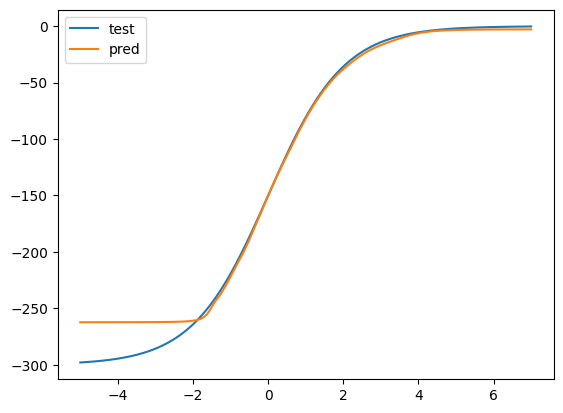

In [29]:
import matplotlib.pyplot as plt
ind = np.argsort(X_train)
plt.plot(X_test, Y_test, label = 'test')
Y_pred = [net.predict_regre(x) for x in X_test]
plt.plot(X_test, Y_pred, label = 'pred')
plt.legend()

In [63]:
train_data = np.genfromtxt(
    "./projekt1/regression/data.cube.train.1000.csv", delimiter=","
)
test_data = np.genfromtxt(
    "./projekt1/regression/data.cube.test.1000.csv", delimiter=","
)
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
minx = min(X_train)
maxx = max(X_train)

net = NeuralNet(
    hidden_layers=3, number_of_neurons_in_layer=30, input_dim=1, activation_f="relu"
)
X_scaled = scale(X_train, minx, maxx)
X_test_scaled = scale(X_test, minx, maxx)
net.train_regre(X_scaled, Y_train, learning_rate=0.0001, epochs=300, print_logs=True)

print(f"RMSE on train data {evaluate_model_regre(net, X_scaled, Y_train)}")
print(f"RMSE on test data {evaluate_model_regre(net, X_test_scaled, Y_test)}")

Epoch: 0, mean loss: 3814.7187300547084
Epoch: 1, mean loss: 3504.71737691517
Epoch: 2, mean loss: 1819.1653550155052
Epoch: 3, mean loss: 3594.659352362361
Epoch: 4, mean loss: 1783.8772300741575
Epoch: 5, mean loss: 2890.727768201016
Epoch: 6, mean loss: 3829.8054472540102
Epoch: 7, mean loss: 4169.048444982082
Epoch: 8, mean loss: 2433.208945732119
Epoch: 9, mean loss: 3700.300728668026
Epoch: 10, mean loss: 1276.0195294239986
Epoch: 11, mean loss: 1971.9111974269345
Epoch: 12, mean loss: 2852.4293032415826
Epoch: 13, mean loss: 1666.6079549392548
Epoch: 14, mean loss: 3576.7012621812905
Epoch: 15, mean loss: 3175.094940991521
Epoch: 16, mean loss: 2374.308083810369
Epoch: 17, mean loss: 2521.398043247868
Epoch: 18, mean loss: 2303.4262079991227
Epoch: 19, mean loss: 3617.3709232398623
Epoch: 20, mean loss: 1851.202317526508
Epoch: 21, mean loss: 2513.514537541245
Epoch: 22, mean loss: 2509.9467613362967
Epoch: 23, mean loss: 2400.175442937077
Epoch: 24, mean loss: 3304.901949713967

In [ ]:
# sigmoid, 3x30 learning rate 0.01, 300 epochs
# RMSE on train data 3.1254500957681346
# RMSE on test data 17.190227673706424

# relu 3x30 learning rate 0.0001, 300 epochs
# RMSE on train data 4.448079014292296
# RMSE on test data 25.028238006497276

# tanh, 3x30, learning rate 0.01, 300 epochs
# RMSE on train data 9.196374889673452
# RMSE on test data 21.779207353578535


# cube
# sigmoid 3x30 learning rate 0.01, 300 epochs
# RMSE on train data 22.56842708360529
# RMSE on test data 304.1637533889077


# relu 3x30 learning rate 0.0001, 300 epochs
# RMSE on train data 29.218189280159933
# RMSE on test data 313.2398128272467

# tanh, 3x30, learning rate 0.01, 300 epochs
# RMSE on train data 14.319983143069551
# RMSE on test data 295.82599861435557

Plot scaled

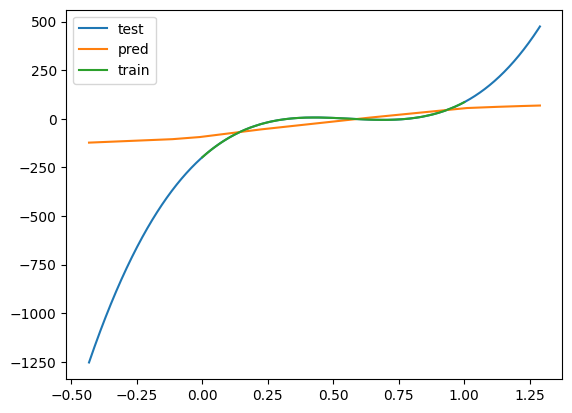

In [64]:

import matplotlib.pyplot as plt
ind = np.argsort(X_train)
plt.plot(X_test_scaled, Y_test, label = 'test')
Y_pred = [net.predict_regre(x) for x in X_test_scaled]
plt.plot(X_test_scaled, Y_pred, label = 'pred')
plt.plot(X_scaled[ind], Y_train[ind], label = 'train')
plt.legend()

Plot not scaled


# Classifcation

In [106]:
train_data = np.genfromtxt(
    "./projekt1/classification/data.simple.train.1000.csv", delimiter=","
)
test_data = np.genfromtxt(
    "./projekt1/classification/data.simple.test.1000.csv", delimiter=","
)
X_train = train_data[1:, :2]
Y_train = train_data[1:, 2]
X_test = test_data[1:, :2]
Y_test = test_data[1:, 2]

net = NeuralNet(
    hidden_layers=3,
    number_of_neurons_in_layer=30,
    input_dim=2,
    number_of_outputs=1,
    activation_f="tanh",
)
net.train_class(X_train, Y_train, learning_rate=0.01, epochs=500, print_logs=True)

print(f"RMSE on train data {evaluate_model_class(net, X_train, Y_train)}")
print(f"RMSE on test data {evaluate_model_class(net, X_test, Y_test)}")

Epoch: 0, mean loss: 1.2335993934837883
Epoch: 1, mean loss: 1.045220041231281
Epoch: 2, mean loss: 1.222678073867461
Epoch: 3, mean loss: 0.8341645148663419
Epoch: 4, mean loss: 1.0117383324198457
Epoch: 5, mean loss: 1.1054360566383958
Epoch: 6, mean loss: 1.1875089170977
Epoch: 7, mean loss: 1.052643200145452
Epoch: 8, mean loss: 1.0696219928183701
Epoch: 9, mean loss: 0.9017728088990605
Epoch: 10, mean loss: 0.9042176843229981
Epoch: 11, mean loss: 0.8262431082332844
Epoch: 12, mean loss: 0.8944038079195363
Epoch: 13, mean loss: 0.8185798154035275
Epoch: 14, mean loss: 0.7827972403198945
Epoch: 15, mean loss: 0.7538372527808745
Epoch: 16, mean loss: 0.7399865624852091
Epoch: 17, mean loss: 0.7997118064889566
Epoch: 18, mean loss: 0.7059451189865134
Epoch: 19, mean loss: 0.7969898593198272
Epoch: 20, mean loss: 0.577403079116546
Epoch: 21, mean loss: 0.6377870619079402
Epoch: 22, mean loss: 0.5774834468984461
Epoch: 23, mean loss: 0.6130316528461639
Epoch: 24, mean loss: 0.681563181

In [74]:
def accuracy(Y_true, Y_pred):
    return sum([1 if y_true == y_pred else 0 for y_true, y_pred in zip(Y_true, Y_pred)]) / len(Y_true)

In [ ]:
# classification simple
# sigmoid 3x30, learning rate 0.01, 500 epochs
# Accuracy on train set
# 0.832
# Accuracy on test set
# 0.815

# RELU 3x30, learning rate 0.01, 500 epochs
# Accuracy on train set
# 0.967
# Accuracy on test set
# 0.956

# tanh 3x30, learning rate 0.01, 500 epochs
# Accuracy on train set
# 0.978
# Accuracy on test set
# 0.972


Accuracy on train set
0.978
Accuracy on test set
0.972


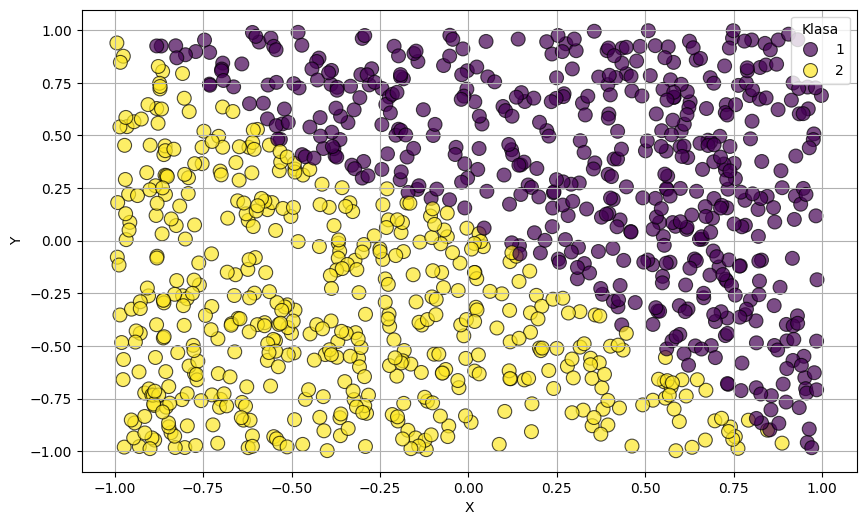

In [107]:
import seaborn as sns
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
C_test = test_data[1:, 2]

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))

C_pred = [1 if net.predict_class(input) < 0.5 else 2 for input in test_data[1:, :2]]
sns.scatterplot(x=X_test, y=Y_test, hue=C_pred, palette='viridis', s=100, edgecolor='k', alpha=0.7)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(title='Klasa')
plt.grid(True)

C_train = train_data[1:, 2]
C_train_pred = [1 if net.predict_class(input) < 0.5 else 2 for input in train_data[1:, :2]]
print("Accuracy on train set")
print(accuracy(C_train, C_train_pred))
print("Accuracy on test set")
print(accuracy(C_test, C_pred))